# MongoDB
- ODBMS.
- Stores data as documents in JSON format. No tables, period!
- Flexibility. Database schema can evolve over time. Imagine a *table* where rows can have variable number of columns.
- Everything is [JSON](https://www.json.org/json-en.html)!


## RDBMS --> ODBMS
- Table --> Collection
- Row   --> Documents

### Two MongoDB documents storing user details:

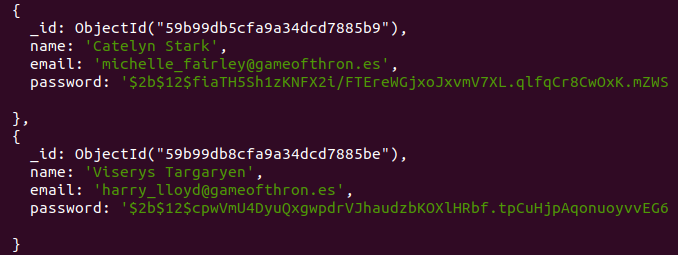

## Connecting to a MongoDB server from Python using [PyMongo](https://pypi.org/project/pymongo/)
- PyMongo package contains tools that we can use to connect to MongoDB instances from Python.
- MongoDB also provides a command line utility called *[mongosh](https://docs.mongodb.com/mongodb-shell/run-commands/)* which we can use to run mongo commands from a shell.
- There are also many other wrappers that provide access to MongoDB from languages like Java, JavaScript etc.
- Dictionary data type is used for representing MongoDB documents in Python.

In [138]:
from pymongo import MongoClient

In [139]:
# Connect to a MongoDB instance running on localhost:
client = MongoClient()# Can also specify the address and port of the server instead of default values

## MongoDB Operations

### List databases

In [140]:
client.list_database_names()

['admin', 'config', 'local', 'sample_mflix', 'test']

### Switch to a database

In [141]:
sample_mflix = client.sample_mflix

### List collections in a database

In [142]:
sample_mflix.list_collection_names()

['users', 'sessions', 'movies', 'theaters', 'comments']

### Collection operations

#### Get the reference to a collection

In [143]:
users = sample_mflix.users

#### Fetch document(s) from a collection

In [144]:
user_cursor = users.find(limit=2) # There's also a 'find_one' method that returns a single document
for user in user_cursor:
    print(user)

{'_id': ObjectId('59b99db5cfa9a34dcd7885b9'), 'name': 'Catelyn Stark', 'email': 'michelle_fairley@gameofthron.es', 'password': '$2b$12$fiaTH5Sh1zKNFX2i/FTEreWGjxoJxvmV7XL.qlfqCr8CwOxK.mZWS'}
{'_id': ObjectId('59b99db8cfa9a34dcd7885be'), 'name': 'Viserys Targaryen', 'email': 'harry_lloyd@gameofthron.es', 'password': '$2b$12$cpwVmU4DyuQxgwpdrVJhaudzbKOXlHRbf.tpCuHjpAqonuoyvvEG6'}


#### Refining queries

In [145]:
user_cursor = users.find({'name': 'Catelyn Stark'}) # Use filter parameter to refine returned results
for user in user_cursor:
    print(user)

{'_id': ObjectId('59b99db5cfa9a34dcd7885b9'), 'name': 'Catelyn Stark', 'email': 'michelle_fairley@gameofthron.es', 'password': '$2b$12$fiaTH5Sh1zKNFX2i/FTEreWGjxoJxvmV7XL.qlfqCr8CwOxK.mZWS'}


In [146]:
user_cursor = users.find({'name': 'Catelyn Stark'}, ['name']) # Specify the fields of a collection to be returned.
for user in user_cursor:
    print(user)

{'_id': ObjectId('59b99db5cfa9a34dcd7885b9'), 'name': 'Catelyn Stark'}


#### Counting documents in a collection

In [147]:
users.count_documents({})

185

In [148]:
users.count_documents({'name': 'Catelyn Stark'})

1

#### Inserting a document into a collection

In [149]:
inserted_result = users.insert_one({'name': 'Neo', 'email': 'neo@nebuchadnezzar.com', 'password': 'Tr1n1ty'})
inserted_result.inserted_id

ObjectId('6150c7f3e4c7f1fd2d244473')

In [150]:
neo = users.find_one({'name': 'Neo'})
neo

{'_id': ObjectId('6150c7f3e4c7f1fd2d244473'),
 'name': 'Neo',
 'email': 'neo@nebuchadnezzar.com',
 'password': 'Tr1n1ty'}

#### Deleting a document

In [151]:
delete_result = users.delete_one({'name': 'Neo'})
delete_result.deleted_count

1

In [152]:
neo = users.find_one({'name': 'Neo'})
print(neo)

None


#### Updating a document

In [153]:
users.insert_one({'name': 'Neo', 'email': 'neo@nebuchadnezzar.com', 'password': 'Tr1n1ty'})

In [154]:
update_result = users.update_one({'name': 'Neo'}, {'$set': {'email': 'neo@matrix.com'}})
update_result.modified_count

1

In [155]:
neo = users.find_one({'name': 'Neo'})
neo

{'_id': ObjectId('6150c7f4e4c7f1fd2d244474'),
 'name': 'Neo',
 'email': 'neo@matrix.com',
 'password': 'Tr1n1ty'}

#### insert_many(), delete_many(), find() can be used to perform the operations listed above on multiple documents.

#### Aggregation
- Processes documents in stages as specified in a pipeline.
- Each stage can alter documents and then pass them onto other stages down the stream.
- Order in which the stages are arranged in a pipeline is important.

##### Simulation of 'Join' using MongoDB aggregation pipeline

In [156]:
comments = sample_mflix.comments
for comment in comments.find({}, limit = 2):
    print(comment)

{'_id': ObjectId('5a9427648b0beebeb69579cf'), 'name': 'Greg Powell', 'email': 'greg_powell@fakegmail.com', 'movie_id': ObjectId('573a1390f29313caabcd41b1'), 'text': 'Tenetur dolorum molestiae ea. Eligendi praesentium unde quod porro. Commodi nisi sit placeat rerum vero cupiditate neque. Dolorum nihil vero animi.', 'date': datetime.datetime(1987, 2, 10, 0, 29, 36)}
{'_id': ObjectId('5a9427648b0beebeb69579dd'), 'name': 'Joshua Kent', 'email': 'joshua_kent@fakegmail.com', 'movie_id': ObjectId('573a1390f29313caabcd42ee'), 'text': 'Corporis pariatur rem autem accusamus debitis. Eaque aspernatur quae accusantium non ea quasi ullam. Assumenda quibusdam blanditiis inventore velit dolorem. Adipisci quaerat quae architecto sint.', 'date': datetime.datetime(1993, 12, 6, 18, 45, 21)}


##### Three stages of the pipeline:
- Stage 1 (Limit): For picking just the required number of documents.
- Stage 2 (Lookup): Join 'users' and 'comments' collections using 'email' as the common field.
- Stage 3 (Project): Remove unnecessary fields.

In [157]:
pipeline = [{"$limit": 1},
            {"$lookup": {'from': 'comments', 
                         'localField': 'email', 
                         'foreignField': 'email',
                         'as': 'comments'}},
            {"$project": {'name': 1, 
                          'email': 1,
                          'comments.text': 1}}]

# Call the aggregate function on 'users' collection passing in the pipeline:
for user in users.aggregate(pipeline):
    print(user)

{'_id': ObjectId('59b99db5cfa9a34dcd7885b9'), 'name': 'Catelyn Stark', 'email': 'michelle_fairley@gameofthron.es', 'comments': [{'text': 'Nesciunt natus nobis provident dolore totam velit. Ullam harum officia laborum nam dolore. Sapiente beatae quidem cum magni accusamus corrupti. Debitis vel tempore fugit quasi veniam.'}, {'text': 'Pariatur eaque cupiditate odit magnam. Iure aut placeat accusantium natus cupiditate. Velit placeat sunt eos eos debitis perferendis suscipit.'}, {'text': 'Explicabo voluptatum soluta sed optio ea. Harum non mollitia natus nostrum earum accusantium itaque. Eum corrupti voluptates nisi reprehenderit. Vel quidem possimus eius laudantium.'}, {'text': 'Placeat aspernatur aperiam sed quas perferendis quasi. Sunt a suscipit maxime commodi consequuntur minus. Laudantium aperiam beatae ipsam dolorem dolore velit.'}, {'text': 'Expedita natus pariatur provident neque ex harum velit. Nobis recusandae iure debitis fugiat tempore doloremque harum. Rem architecto nam ad 

## References
- [JSON](https://www.json.org/json-en.html)
- [Movies Dataset](https://github.com/neelabalan/mongodb-sample-dataset/tree/main/sample_mflix)
- [PyMongo Tutorial](https://pymongo.readthedocs.io/en/stable/tutorial.html)
- [PyMongo API Docs](https://pymongo.readthedocs.io/en/stable/api/pymongo/index.html)
- [MongoDB Operators](https://docs.mongodb.com/manual/reference/operator/)
- [Aggregation Stages](https://docs.mongodb.com/manual/reference/operator/aggregation-pipeline/)